<a href="https://colab.research.google.com/github/google/neural-tangents/blob/main/notebooks/Disentangling_Trainability_and_Generalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
!pip install -q --upgrade pip
!pip install -q --upgrade jax[cuda11_cudnn805] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -q git+https://www.github.com/google/neural-tangents

In [ ]:
#@title Imports & Utils

import numpy as onp
import jax.numpy as np

from jax.example_libraries import optimizers
from jax import grad, jit, vmap
from jax import lax
from jax.config import config
config.update('jax_enable_x64', True)

from functools import partial
from jax import random

import tensorflow_datasets as tfds

import neural_tangents as nt
from neural_tangents import stax

# Kernel Construction

_Kernel = nt._src.utils.kernel.Kernel

def Kernel(K):
  """Create an input Kernel object out of an np.ndarray."""
  return _Kernel(cov1=np.diag(K), nngp=K, cov2=None,
                 ntk=None, is_gaussian=True, is_reversed=False,
                 diagonal_batch=True, diagonal_spatial=False,
                 batch_axis=0, channel_axis=1, mask1=None, mask2=None,
                 shape1=(2, 1024), shape2=(2,1024),
                 x1_is_x2=True, is_input=True)

def NTKernel(var1, nngp, var2, ntk):
  """Create an input Kernel object out of an np.ndarray."""
  return _Kernel(cov1=var1, nngp=nngp, cov2=var2,
                ntk=ntk, is_gaussian=True, is_reversed=False,
                diagonal_batch=True, diagonal_spatial=False,
                batch_axis=0, channel_axis=1, mask1=None, mask2=None,
                shape1=(2, 1024), shape2=(2,1024),
                x1_is_x2=True, is_input=True)

def wrap(kernel_fn):
  def wrapped_fn(kernel):
    out = kernel_fn(NTKernel(*kernel))
    return kernel._replace(
        cov1=out.cov1, nngp=out.nngp, cov2=out.cov2, ntk=out.ntk)
  return wrapped_fn

def fixed_point(f, initial_value, threshold):
  """Find fixed-points of a function f:R->R using Newton's method."""
  g = lambda x: f(x) - x
  dg = grad(g)

  def cond_fn(x):
    x, last_x = x
    return np.abs(x - last_x) > threshold

  def body_fn(x):
    x, _ = x
    return x - g(x) / dg(x), x

  return lax.while_loop(cond_fn, body_fn, (initial_value, 0.0))[0]

# TODO: This is necessary because of a bug in NT's CPU detection inside a jit
nt.predict._arr_is_on_cpu = lambda x: False


def scale(a, b):
  return a * b[-1] / a[-1]


def normalize(x_train, y_train, x_test, y_test):
  x_train = x_train / np.sqrt(np.reshape(np.einsum('ij,ij->i', x_train, x_train), (64, 1))) * np.sqrt(x_train.shape[-1])
  y_train = y_train - np.mean(y_train, axis=0, keepdims=True)
  x_test = x_test / np.sqrt(np.reshape(np.einsum('ij,ij->i', x_test, x_test), (32, 1))) * np.sqrt(x_test.shape[-1])
  return x_train, y_train, x_test, y_test

# Data Loading

def _partial_flatten_and_normalize(x):
  """Flatten all but the first dimension of an `np.ndarray`."""
  x = onp.reshape(x, (x.shape[0], -1))
  return (x - onp.mean(x)) / onp.std(x)


def _one_hot(x, k, dtype=np.float32):
  """Create a one-hot encoding of x of size k."""
  return onp.array(x[:, None] == onp.arange(k), dtype)


def get_dataset(name, n_train=None, n_test=None, permute_train=False,
                do_flatten_and_normalize=True):
  """Download, parse and process a dataset to unit scale and one-hot labels."""
  ds_builder = tfds.builder(name)

  ds_train, ds_test = tfds.as_numpy(
      tfds.load(
          name + ':3.*.*',
          split=['train' + ('[:%d]' % n_train if n_train is not None else ''),
                 'test' + ('[:%d]' % n_test if n_test is not None else '')],
          batch_size=-1,
          as_dataset_kwargs={'shuffle_files': False}))

  train_images, train_labels, test_images, test_labels = (ds_train['image'],
                                                          ds_train['label'],
                                                          ds_test['image'],
                                                          ds_test['label'])

  if do_flatten_and_normalize:
    train_images = _partial_flatten_and_normalize(train_images)
    test_images = _partial_flatten_and_normalize(test_images)

  num_classes = ds_builder.info.features['label'].num_classes
  train_labels = _one_hot(train_labels, num_classes)
  test_labels = _one_hot(test_labels, num_classes)

  if permute_train:
    perm = onp.random.RandomState(0).permutation(train_images.shape[0])
    train_images = train_images[perm]
    train_labels = train_labels[perm]

  return train_images, train_labels, test_images, test_labels

# Plotting

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_style(style='white')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def format_plot(title='', x='', y='', grid=True):
  ax = plt.gca()

  plt.grid(grid)
  if title:
    plt.title(title, fontsize=18)
  plt.xlabel(x, fontsize=16)
  plt.ylabel(y, fontsize=16)

def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1],
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

# Disentangling Trainability and Generalization in Deep Neural Networks

Here we present a notebook that goes through the essential results in [Xiao et al.](). We have prioritized pedegogy and interactivity over large-scale experiments and rigor here. For the latter results, we suggest looking to the paper for details. The overarching goal of this work is to connect recent work on function priors learned by neural networks to training dynamics via the neural tangent kernel. As such, we will first recapitulate some recent work qualitatively relating function priors in deep neural networks with trainability. We will then describe our contribution in which we make this connection rigorous. A surprising result we will come to is that there are a wide range of neural network configurations in which the networks can be trained but become completely unable to generalize. We will precisely characterize this regime and the associated crossover to a generalizing regime.

## Phase Diagram

We will begin by reproducing the results described in [Poole et al.](https://papers.nips.cc/paper/6322-exponential-expressivity-in-deep-neural-networks-through-transient-chaos) and [Schoenholz et al.](https://arxiv.org/abs/1611.01232) before moving on to describe the contribution of [Xiao et al.](). In these and subsequent papers, it was found that deep neural networks can exhibit a phase transition as a function of the variance of their weights ($\sigma_w^2$) and biases ($\sigma_b^2$). For networks with $\tanh$ activation functions, this phase transition is between an "ordered" phase and a "chaotic" phase. In the ordered phase, pairs of inputs collapse to a single point as they propagate through the network. By contrast, in the chaotic phase, nearby inputs become increasingly dissimilar in later layers of the network. This phase diagram is shown below.

\

![Phase Diagram](https://raw.githubusercontent.com/google/neural-tangents/main/notebooks/figures/pennington_phase_diagram.svg?sanitize=true)

> Phase diagram for $\tanh$ neural networks (appeared in [Pennington et al.](https://arxiv.org/abs/1802.09979)).

\

Consider two inputs to a neural network, $x_1$ and $x_2$, normalized such that $\|x_1\| = \|x_2\| = q^0$. We can compute the cosine-angle between the inputs, $c^0 = \cos\theta_{12} = \frac{x_1 \cdot x_2}{q^0}$. Additionally, we can keep track of the norm and cosine angle of the resulting pre-activations ($q^l$ and $c^l$ respectively) as signal passes through layers of the neural network. In the wide-network limit there are deterministic functions, called the $\mathcal Q$-map and the $\mathcal{C}$-map, such that $q^{l+1} = \mathcal Q(q^l)$ and $c^{l+1} = \mathcal C(q^l, c^l)$.

\

In fully-connected networks with $\tanh$-like activation functions, both the $\mathcal Q$-map and $\mathcal C$-map have unique stable-fixed-points, $q^*$ and $c^*$, such that $q^* = \mathcal Q(q^*)$ and $c^* = \mathcal C(q^*, c^*)$. To simplify the discussion, we typically choose to normalize our inputs so that $q^0 = q^*$ and we can restrict our study to the $\mathcal C$-map. The $\mathcal C$-map always has a fixed point at $c^* = 1$ since two identical inputs will remain identical as they pass through the network. However, this fixed point is not always stable and two points that start out very close together will often separate. Indeed, the ordered and chaotic phases are characterized by the stability of the $c^* = 1$ fixed point. In the ordered phase $c^* = 1$ is stable and pairs of inputs converge to one another as they pass through the network. In the chaotic phase the $c^* = 1$ point is unstable and a new, stable, fixed point with $c^* < 1$ emerges. The phase boundary is defined as the point where $c^* = 1$ is marginally stable.

\

To understand the stability of a fixed point, $c^*$, we will use the standard technique in Dynamical Systems theory and expand the $\mathcal C$-map in $\epsilon^l = c^l - c^*$ which implies that $\epsilon^{l+1} = \chi(c^*)\epsilon^l$ where $\chi = \frac{\partial\mathcal C}{\partial C}$. This implies that sufficiently close to a fixed point of the dynamics, $\epsilon^l = \chi(c^*)^l$. If $\chi(c^*) < 1$ then the fixed point is stable and points move towards the fixed point exponentially quickly. If $\chi(c^*) > 1$ then points move away from the fixed point exponentially quickly. This implies that the phase boundary, being defined by the marginal stability of $c^* = 1$, will be where $\chi_1 = \chi(1) = 1$.

\

To reproduce these results in Neural Tangents, we notice first that the $\mathcal{C}$-map described above is intimately related to the NNGP kernel, $K^l$, of [Lee et al.](https://arxiv.org/abs/1711.00165), [Matthews et al.](https://arxiv.org/abs/1804.11271), and [Novak et al.](https://arxiv.org/abs/1810.05148). The core of Neural Tangents is a map $\mathcal T$ for a wide range of architectures such that $K^{l + 1} = \mathcal T(K^l)$. Since $c^l$ can be written in terms of the NNGP kernel as $c^l = K^l_{12} / q^*$ this implies that Neural Tangents provides a way of computing the $\mathcal{C}$-map for a wide range of network architectures.

\

To produce the phase diagam above, we must compute $q^*$ and $c^*$ as well as $\chi_1$. We will use a fully-connected network with $\text{Erf}$ activation functions since they admit an analytic kernel function and are very similar to $\tanh$ networks. We will first define the $\mathcal Q$-map by noting that the $\mathcal Q$-map will be identical to $\mathcal T$ if the covariance matrix has only a single entry. We will use Newton's method to find $q^*$ given the $\mathcal Q$-map. Next we will use the relationship above to define the $\mathcal C$-map in terms of $\mathcal T$. We will again use Newton's method to find the stable $c^*$ fixed point. We can define $\chi$ by using JAX's automatic differentiation to compute the derivative of the $\mathcal C$-map. This can be written relatively concisely below.

\

Note: this particular phase diagram holds for a wide range of neural networks but, emphatically, not for ReLUs. The ReLU phase diagram is somewhat different and could be investigated using Neural Tangents. However, we will save it for a followup notebook.

In [ ]:
def qc_map(W_var, b_var):
  W_std = np.sqrt(W_var)
  b_std = np.sqrt(b_var)

  # Create a single layer of a network as an affine transformation composed
  # with an Erf nonlinearity.
  kernel_fn = stax.serial(stax.Erf(), stax.Dense(1024, W_std, b_std))[2]

  def q_map_fn(q):
    return kernel_fn(Kernel(np.array([[q]]))).nngp[0, 0]
  qstar = fixed_point(q_map_fn, 1.0, 1e-7)

  def c_map_fn(c):
    K = np.array([[qstar, qstar * c], [qstar * c, qstar]])
    K_out = kernel_fn(Kernel(K)).nngp
    return K_out[1, 0] / qstar

  return q_map_fn, c_map_fn

c_map = lambda W_var, b_var: qc_map(W_var, b_var)[1]
q_map = lambda W_var, b_var: qc_map(W_var, b_var)[0]

q_star = lambda W_var, b_var: fixed_point(q_map(W_var, b_var), 1., 1e-7)
c_star = lambda W_var, b_var: fixed_point(c_map(W_var, b_var), 0.5, 1e-7)
chi = lambda c, W_var, b_var: grad(c_map(W_var, b_var))(c)
chi_1 = partial(chi, 1.)
chi_c = lambda W_var, b_var: grad(c_map(W_var, b_var))(c_star(W_var, b_var))

To generate the phase diagram above, we would like to compute the fixed-point correlation not only at a single value of $(\sigma_w^2,\sigma_b^2)$ but on a whole mesh. We can use JAX's `vmap` functionality to do this.

In [ ]:
def vectorize_over_sw_sb(fn):
  # Vectorize over the weight variance.
  fn = vmap(fn, (0, None))
  # Vectorize over the bias variance.
  fn = vmap(fn, (None, 0))

  return fn

vq_star = jit(vectorize_over_sw_sb(q_star))
vc_star = jit(vectorize_over_sw_sb(c_star))
vchi_1 = jit(vectorize_over_sw_sb(chi_1))

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_py3_schsam.kernel.schsam.263115371177.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_py3_schsam.kernel.schsam.263115371177.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/IPython/core/formatters.py:249: FormatterWarning: application/pdf formatter returned invalid type <class 'bytes'> (expected (<class 'str'>,)) for object: <Figure size 1050x450 with 4 Axes>


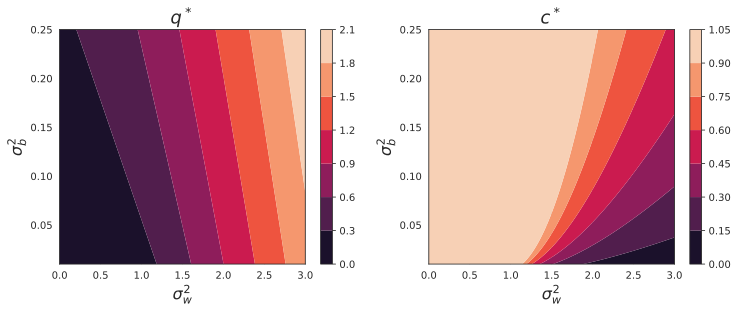

In [ ]:
W_var = np.arange(0, 3.01, 0.01)
b_var = np.arange(0.01, 0.251, 0.001)

plt.subplot(1, 2, 1)
plt.contourf(W_var, b_var, vq_star(W_var, b_var))
plt.colorbar()
format_plot('$q^*$', '$\\sigma_w^2$', '$\\sigma_b^2$')

plt.subplot(1, 2, 2)
plt.contourf(W_var, b_var, vc_star(W_var, b_var))
plt.colorbar()
format_plot('$c^*$', '$\\sigma_w^2$', '$\\sigma_b^2$')

finalize_plot((1.75, 0.75))

Here we see that, as expected, there are well defined regimes with $c^* = 1$ and $c^* < 1$ respectively. We can, of course, threshold on $c^*$ to get a cleaner definition of the two phases.

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_py3_schsam.kernel.schsam.263115371177.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/IPython/core/formatters.py:249: FormatterWarning: application/pdf formatter returned invalid type <class 'bytes'> (expected (<class 'str'>,)) for object: <Figure size 450x450 with 1 Axes>


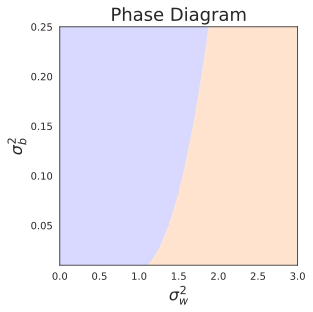

In [ ]:
plt.contourf(W_var, b_var, vc_star(W_var, b_var) > 0.999,
             levels=3,
             colors=[[1.0, 0.89, 0.811], [0.85, 0.85, 1]])
format_plot('Phase Diagram', '$\\sigma_w^2$', '$\\sigma_b^2$')
finalize_plot((0.75, 0.75))


As described above, the boundary between the two phases should be defined by $\chi_1(\sigma_w^2, \sigma_b^2) = 1$ where $\chi_1$ is given by the derivative of the $\mathcal C$-map. We can use Neural Tangents combined with JAX's automatic differentiation to easily compute $\chi_1$.

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_py3_schsam.kernel.schsam.263115371177.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/IPython/core/formatters.py:249: FormatterWarning: application/pdf formatter returned invalid type <class 'bytes'> (expected (<class 'str'>,)) for object: <Figure size 540x450 with 2 Axes>


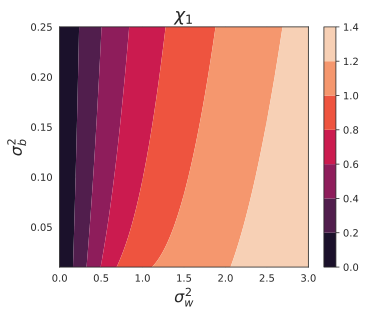

In [ ]:
plt.contourf(W_var, b_var, vchi_1(W_var, b_var))
plt.colorbar()
format_plot('$\\chi_1$', '$\\sigma_w^2$', '$\\sigma_b^2$')
finalize_plot((0.9, 0.75))

We can see that the boundary where $\chi_1$ crosses 1 corresponds to the phase boundary we observe above.

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_py3_schsam.kernel.schsam.263115371177.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/IPython/core/formatters.py:249: FormatterWarning: application/pdf formatter returned invalid type <class 'bytes'> (expected (<class 'str'>,)) for object: <Figure size 600x600 with 1 Axes>


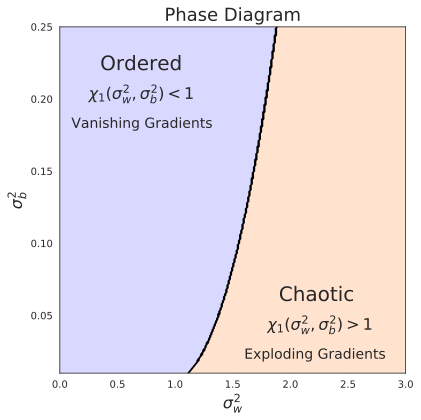

In [ ]:
plt.contourf(W_var, b_var, vc_star(W_var, b_var) > 0.999,
             levels=3,
             colors=[[1.0, 0.89, 0.811], [0.85, 0.85, 1]])
plt.contourf(W_var, b_var,
             np.abs(vchi_1(W_var, b_var) - 1) < 0.003,
             levels=[0.5, 1],
             colors=[[0, 0, 0]])
plt.text(.35, .22, 'Ordered', fontsize=20)
plt.text(.1, .18, 'Vanishing Gradients', fontsize=14)
plt.text(.25, .20, '$\\chi_1(\\sigma_w^2, \\sigma_b^2)<1$', fontsize=16)
plt.text(1.9, .06, 'Chaotic', fontsize=20)
plt.text(1.6, .02, 'Exploding Gradients', fontsize=14)
plt.text(1.8, .04, '$\\chi_1(\\sigma_w^2, \\sigma_b^2)>1$', fontsize=16)

format_plot('Phase Diagram', '$\\sigma_w^2$', '$\\sigma_b^2$')
finalize_plot((1, 1))

## Depth Scales for Signal Propagation

As described above, not only does $\chi(c^*)$ determine the stability of the fixed point, $c^*$, but it also determines the rate of convergence to the fixed point. To see this, we can plot $c^l$ as a function of the depth of the network; we will then compare the dynamics of $\epsilon^l = c^l - c^*$ with $\chi(c^*)^l$. We can do this for one point in the ordered phase and one point in the chaotic phase. We will assume that $c^0 = 1/2$, which is an arbitrary choice. Although $\chi(c^*)$ describes the asymptotic scaling of $\epsilon^l$ with $l$, there is an arbitrary choice of prefactor. We will take this to be $\epsilon^0$ for simplicity.

We first define a function `compute_c` which computes $c^l$ for some number of layers. Then we plot the $c^l$ and the distance of $c^l$ from its fixed point for two choices of $(\sigma_w^2, \sigma_b^2)$.

In [ ]:
@jit
def compute_c(W_var, b_var, layers):
  c = c_map(W_var, b_var)
  return lax.scan(lambda c_l, l: (c(c_l), c_l), 0.5, layers)[1]

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_py3_schsam.kernel.schsam.263115371177.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/IPython/core/formatters.py:249: FormatterWarning: application/pdf formatter returned invalid type <class 'bytes'> (expected (<class 'str'>,)) for object: <Figure size 900x360 with 2 Axes>


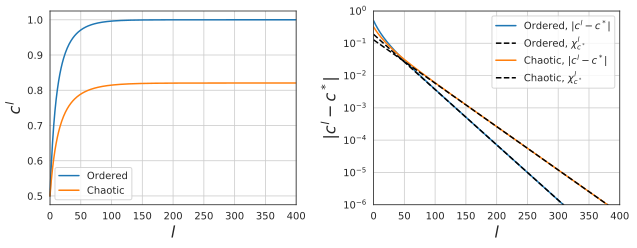

In [ ]:
b = 0.05
W_ordered = 1.25
W_chaotic = 1.5
layers = np.arange(400)
nlayers = len(layers)

# Compute c^l as a function of layer number.

plt.subplot(1, 2, 1)
plt.plot(compute_c(W_ordered, b, layers), label='Ordered')
plt.plot(compute_c(W_chaotic, b, layers), label='Chaotic')
plt.legend()
plt.xlim([0, nlayers])

format_plot('', '$l$', '$c^l$')

# Compute c^l - c* and compare to \chi_{c*}^l.

plt.subplot(1, 2, 2)
eps = np.abs(compute_c(W_ordered, b, layers) - c_star(W_ordered, b))
plt.semilogy(eps, color=colors[0], label='Ordered, $|c^l - c^*|$')
plt.semilogy(scale(chi_c(W_ordered, b) ** layers * eps[0], eps), 'k--',
             label='Ordered, $\\chi_{c^*}^l$')

eps = np.abs(compute_c(W_chaotic, b, layers) - c_star(W_chaotic, b))
plt.semilogy(eps, color=colors[1], label='Chaotic, $|c^l - c^*|$')
plt.semilogy(scale(chi_c(W_chaotic, b) ** layers * eps[0], eps), 'k--',
             label='Chaotic, $\\chi_{c^*}^l$')
plt.ylim([10 ** - 6, 10 ** 0])
plt.xlim([0, nlayers])

format_plot('', '$l$', '$|c^l - c^*|$')
plt.legend()

finalize_plot((1.5, 0.6))

We see that $\chi_{c^*}^l$ does a good job of describing the asymptotic dynamics of the $\mathcal C$-map. This naturally allows us to define a depth scale, $\xi = -1 / \log \chi_{c^*}$ that describes the number of layers over which $c^l$ converges to $c^*$ regardless of the inputs. When $c^l$ is close enough to its fixed point that it cannot be discerned within floating point precision, this implies that the network discards second-moment statistics about its inputs. A number of papers including [Schoenholz et al.](https://arxiv.org/abs/1611.01232), [Yang and Schoenholz](http://papers.nips.cc/paper/6879-mean-field-residual-networks-on-the-edge-of-chaos), [Xiao et al.](https://arxiv.org/abs/1806.05393), [Chen et al.](https://arxiv.org/abs/1806.05394), and [Yang et al.](https://arxiv.org/abs/1902.08129) have shown that neural networks can be trained precisely when their depth is not much greater than $\xi$.

\

Since criticality is defined as the place where $\chi_1 = 1$, this implies that the depth scale $\xi$ diverges at the order-to-chaos transition. A corollary to this is that very deep neural network ought to be trainable sufficiently close to their critical point. Recently, this allowed [Xiao et al.]() to train a 10,000 hidden layer, vanilla, convolutional neural network. We can plot the depth scale for several choices of $\sigma_w^2$ to confirm that it actually diverges at the critical point.

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_py3_schsam.kernel.schsam.263115371177.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/IPython/core/formatters.py:249: FormatterWarning: application/pdf formatter returned invalid type <class 'bytes'> (expected (<class 'str'>,)) for object: <Figure size 540x360 with 1 Axes>


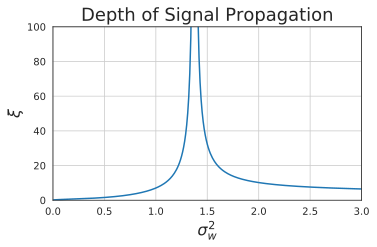

In [ ]:
vchi_c = jit(vmap(chi_c, (0, None)))  # Vectorize of \sigma_w^2.

plt.plot(W_var, -1 / np.log(vchi_c(W_var, 0.05)))
plt.ylim([0, 100])
plt.xlim([0, 3])

format_plot('Depth of Signal Propagation', '$\\sigma_w^2$', '$\\xi$')
finalize_plot((0.9, 0.6))

Include figure from, maybe, Reviews of Condensed Matter Physics paper.

Do we want to include something on critical dynamics here?

# From Correlation to Causation via the Neural Tangent Kernel

The correlation between trainability and signal propagation has been robustly observed over many architectures. Historically, however, there has not been a way of directly connecting properties of the prior with training dynamics. Recently, a set of papers beginning with [Jacot et al.](https://arxiv.org/abs/1806.07572) and continuing with [Lee et al.](https://arxiv.org/abs/1902.06720) and [Chizat](https://arxiv.org/abs/1812.07956) have shown that in the wide network limit the training of neural networks simplifies considerably. In particular, with an MSE loss, the predictions of wide neural networks on training points over the course of training will follow the dynamics:

$$
f_t(\mathcal X_{\text{train}}) = (I - e^{-\eta \Theta t})\mathcal Y_{\text{train}}
$$

where $\mathcal X_{\text{train}}$ and $\mathcal Y_{\text{train}}$ are the training inputs and labels respectively, $\Theta = \Theta(\mathcal X_{\text{train}}, \mathcal X_{\text{train}})$ is called the Neural Tangent Kernel evaluated over the training points, and $\eta$ is the learning rate. Additionally, predictions on the test-points will evolve as,

$$
f_t(\mathcal X_{\text{test}}) = \Theta(\mathcal X_{\text{test}}, \mathcal X_{\text{train}}) \Theta^{-1} (I - e^{-\eta \Theta t})\mathcal Y_{\text{train}}.
$$

From these two relationships, it is clear that the spectrum of the NTK will be intimately related to the training dynamics of the network. Indeed, we should expect that the timescale for learning will be controlled by the condition number $\kappa = \lambda_{\text{max}} / \lambda_{\text{min}}$. Moreover, the overlap between the spectrum of the NTK on training and test points respectively will control generalization. To quantify this, we introduce the "mean predictor" $P(\Theta) = \Theta(\mathcal X_{\text{test}}, \mathcal X_{\text{train}}) \Theta^{-1}$.

\

As alluded to above the NNGP kernel $\mathcal K$ and the NTK $\Theta$ from layer $l$ to layer $(l+1)$ can be written as a coupled set of recurrence relations:
\begin{align}
\mathcal K^{(l+1)} (x, x') &= \sigma_w^2 \mathcal T(\mathcal K^{(l)})(x, x') + \sigma_b^2
\\
 \Theta^{(l+1)}(x, x') &= \mathcal K^{(l+1)} (x, x') + \sigma_w^2\dot{\mathcal T}(\mathcal K^{(l)} )(x, x')\Theta ^{(l)}(x, x')\,.
\end{align}
We can use Neural Tangents to compute the NTK for a range of neural network architectures as a function of their depth. As in the previous section we can consider the large-depth limit of the above recurrence relation and we will see that $\Theta$ approaches a well-defined fixed point $\Theta^* f(l)$ where $f(l)$ is a data-independent function of depth. From the above discussion, it is clear that generalization will break down if $P(\Theta^l)$ becomes data-independent. To determine whether this has happened we will contract $P(\Theta^l)$ with mean-centered labels, $P(\Theta^l)Y_{\text{train}}$. This quantity will be zero if the mean predictor has no data dependence and will otherwise be nonzero.

\

The main results of [Xiao et al.]() are to relate the spectrum of the NTK and the mean predictor to the phase diagram above in the large-depth limit. This will give us precise and testable predictions about when neural networks should be trainable, when they should generalize, and when these two concepts diverge from one another. To begin, we will first define a function to compute the NTK as a function of depth for two sets of inputs. We will also want to  compute the spectrum of the NTK as well as the conditioning number and so we define some helper functions here.


In [ ]:
def ntk(W_var, b_var, layers):
  W_std, b_std = map(np.sqrt, (W_var, b_var))
  # Helper function to create a kernel out of inputs.
  readin_fn = partial(stax.Dense(1024, 1.0, 0.0)[2],
                      get=('cov1', 'nngp', 'cov2', 'ntk'))
  # Function to compute the NTK after a single layer of the network.
  _layer_fn = wrap(stax.serial(stax.Erf(), stax.Dense(1024, W_std, b_std))[2])
  layer_fn = lambda Theta_l, l: (_layer_fn(Theta_l), Theta_l.ntk)

  return jit(lambda X1, X2: lax.scan(layer_fn, readin_fn(X1, X2), layers)[1])

@jit
def spectral_info(kernels):
  @vmap
  def spectral_fn(kernel):
    evals = np.linalg.eigh(kernel)[0]
    return evals[0], evals[-1], evals[-1] / evals[0]
  return spectral_fn(kernels)

def mean_predictor(ntk_fn, x_train, y_train, x_test, reg=0.):
  ktd = ntk_fn(x_test, x_train)
  kdd = ntk_fn(x_train, x_train)
  @vmap
  def inv(k):
    return np.linalg.inv(k + reg * np.eye(k.shape[0]))
  return np.einsum('ijk,ikl,lm->ijm', ktd, inv(kdd), y_train)

Unlike in the above discussion, here we would like to compare our results to the spectrum of the NTK on real data. For this purpose we will use a small subset of CIFAR10 composed of 64 training inputs and 32 test inputs. We will load this now. Of course, you could choose a subset of different sizes if you are happy to wait longer for the computations to finish.

In [ ]:
x_train, y_train, x_test, y_test = normalize(*get_dataset('cifar10', 64, 32))

With the data loaded and the spectrum defined, we will now go through the different phases discussed above and describe the behavior of the spectrum and the mean predictor in the large depth limit.

### Chaotic Phase

We will start out by describing the diagonal and off-diagonal terms of the NTK in the large depth limit. We predict in [Xiao et al.]() that the diagonal terms will diverge as $\chi(1)^l$ while the off-diagonal terms will converge to $\Theta_{ab}^* = q^*c^* / (1-\chi(c^*))$.

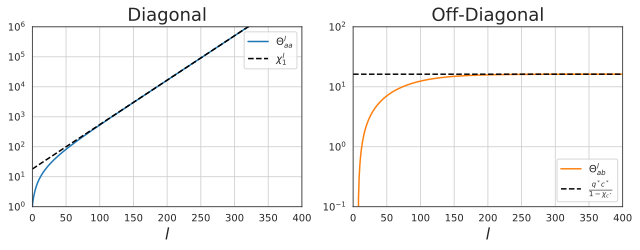

In [ ]:
W = W_chaotic

theta = ntk(W, b, layers)(x_train, x_train)

plt.subplot(1, 2, 1)

# Plot the diagonal term against \chi_1.
plt.semilogy(theta[:, 0, 0], color=colors[0], label='$\\Theta^l_{aa}$')
plt.semilogy(scale(chi_1(W, b) ** layers, theta[:, 0, 0]), 'k--', label='$\\chi_1^l$')

plt.ylim([10 ** 0, 10 ** 6])
plt.xlim([0, nlayers])
plt.legend()

format_plot('Diagonal', '$l$')

plt.subplot(1, 2, 2)

# Plot the off-diagonal term against q*c* / (1 - chi_c*).
plt.semilogy(theta[:, 0, 1], color=colors[1], label='$\\Theta^l_{ab}$')
p_star = q_star(W, b) * c_star(W, b) / (1 - chi_c(W, b))
plt.semilogy([layers[0], layers[-1]], [p_star, p_star], 'k--',
             label='$\\frac{q^*c^*}{1 - \\chi_{c^*}}$')
plt.ylim([10 ** -1, 10 ** 2])
plt.xlim([0, nlayers])
plt.legend()

format_plot('Off-Diagonal', '$l$')
finalize_plot((1.5, 0.6))

From the above we see that in the chaotic phase, asymptotically the NTK will look like the identity matrix scaled by $\chi_1^l$ along with a negligible correction. Thus, we expect all of the eigenvalues of the NTK to grow without bound as $\chi_1^l$. This implies that the conditioning number of the NTK should converge to 1.

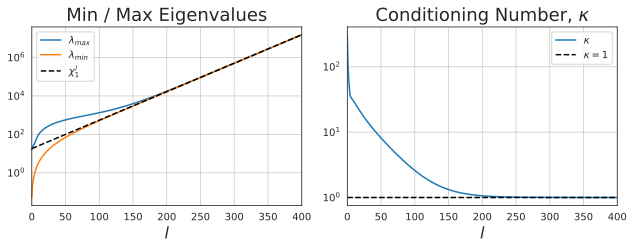

In [ ]:
W = W_chaotic

lambda_min, lambda_max, kappa = spectral_info(theta)

plt.subplot(1, 2, 1)

plt.semilogy(lambda_max, label='$\\lambda_{max}$')
plt.semilogy(lambda_min, label='$\\lambda_{min}$')
plt.semilogy(scale(chi_1(W_chaotic, b) ** layers, lambda_max), 'k--', label='$\\chi_1^l$')
plt.xlim([0, nlayers])

plt.legend()

format_plot('Min / Max Eigenvalues', '$l$')

plt.subplot(1, 2, 2)

plt.semilogy(kappa, label='$\\kappa$')
plt.semilogy([layers[0], layers[-1]], [1, 1], 'k--', label='$\\kappa=1$')
plt.xlim([0, nlayers])

plt.legend()

format_plot('Conditioning Number, $\\kappa$', '$l$')
finalize_plot((1.5, 0.6))

We see good agreement between the scaling of the spectral properties of $\Theta$ and the predictions from our theory. Moreover, in the chaotic phase we see that the conditioning number of the network approaches 1 and so we should expect deep chaotic networks to train quickly.

\

To discuss generalization, we must consider the mean predictor. Since $\Theta(\mathcal X_{\text{test}},\mathcal X_{\text{train}})$ has no "diagonal" terms, we notice that the mean predictor will be inversely proportional to the diagonal terms of $\Theta$ and so $P(\Theta^l)\to 0$. Thus we expect the mean predictor to scale like $O\left(l\left(\frac{\chi_{c^*}}{\chi_{1}}\right)^l\right)$ which will go to zero as depth increases. We can confirm this prediction now.

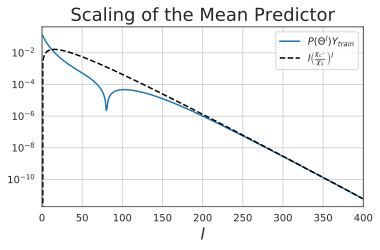

In [ ]:
W = W_chaotic

delta = mean_predictor(ntk(W, b, layers), x_train, y_train, x_test)

plt.semilogy(np.abs(delta[:, 0, 0]), label='$P(\\Theta^l)Y_{train}$')
plt.semilogy(
    scale((layers * (chi_c(W, b) / chi_1(W, b)) ** layers), -delta[:, 0, 0]),
    'k--', label='$l\\left(\\frac{\\chi_{c^*}}{\\chi_1}\\right)^l$')
plt.xlim([0, nlayers])
plt.legend()

format_plot('Scaling of the Mean Predictor', '$l$')
finalize_plot((0.9, 0.6))

We can see that the observed scaling agrees with the theory. Since the mean predictor goes to zero, at sufficiently large depths it becomes completely data independent and we predict that while deep chaotic networks ought to be trainable, they will not generalize if they are sufficiently deep. As above, we can extract a depth-scale that will control the transition to ungeneralizability, $\xi = -1 / (\log\chi_{c^*} - \log\chi_1)$. As with the depth-scale above, this also diverges at the order-to-chaos transition leading to the conclusion that we can train well-behaved networks of large depth there.

### Ordered Phase

As above, we now describe the scaling of the elements of the NTK and properties of its spectrum in the ordered phase. We will then move on to discuss the scaling of the mean predictor. Unlike in the chaotic phase, in the ordered phase we expect the NTK to converge to the constant matrix all of whose entries have the value $p^* = \Theta_{aa}^* = \Theta_{ab}^* = q^* / (1 - \chi_1)$. We expect the diagonals to converge faster than the off-diagonals as $\Theta_{aa}^l - \Theta_{aa}^* = \mathcal O(\chi_1^l)$ and $\Theta_{ab}^l - \Theta_{ab}^*=\mathcal O(l\chi_1^l)$ respectively.

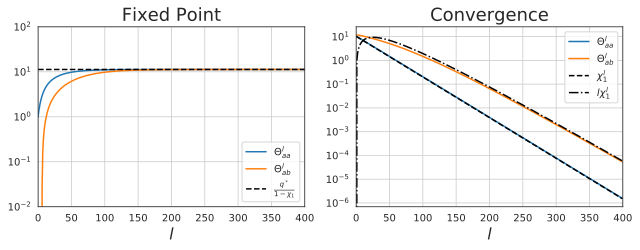

In [ ]:
W = W_ordered

theta = ntk(W, b, layers)(x_train, x_train)

plt.subplot(1, 2, 1)

# Plot the diagonal and off-diagonal terms against the fixed point prediction.
plt.semilogy(theta[:, 0, 0], label='$\\Theta^l_{aa}$')
plt.semilogy(theta[:, 1, 0], label='$\\Theta^l_{ab}$')
p_star = q_star(W, b) / (1 - chi_1(W, b))
plt.semilogy([0, nlayers], [p_star, p_star], 'k--', label='$\\frac{q^*}{1 - \\chi_1}$')

plt.ylim([10 ** -2, 10 ** 2])
plt.xlim([0, nlayers])
plt.legend()

format_plot('Fixed Point', '$l$')

plt.subplot(1, 2, 2)

# Plot the convergence of both terms against the prediction.
dtheta = p_star - theta
plt.semilogy(dtheta[:, 0, 0], label='$\\Theta^l_{aa}$')
plt.semilogy(dtheta[:, 1, 0], label='$\\Theta^l_{ab}$')
plt.semilogy(chi_1(W, b) ** layers * dtheta[0, 0, 0], 'k--', label='$\\chi_1^l$')
plt.semilogy(layers * chi_1(W, b) ** layers, 'k-.', label='$l\\chi_1^l$')

plt.xlim([0, nlayers])
plt.legend()

format_plot('Convergence', '$l$')
finalize_plot((1.5, 0.6))

As in the chaotic phase, we can reason about the asymptotic form of the NTK to understand how its spectrum evolves with depth. Since both the diagonal and off-diagonal terms converge to the same value, the NTK converges to the $p^* 1^T 1$ matrix. This matrix has only two distinct eigenvalues: a single large eigenvalue, $\lambda_{\text{max}} = mp^*$ where $m$ is the dataset size and $m$-eigenvalues, $\lambda_{\text{min}} = 0$. We can also show from the convergence of the diagonal and off-diagonal terms that $\lambda_{\text{min}}$ converges to zero with rate $O(\chi_1^l l)$. This implies that the conditioning number scales as $\kappa^{(l)} \gtrsim \frac {1}{l\chi_1^l}$.

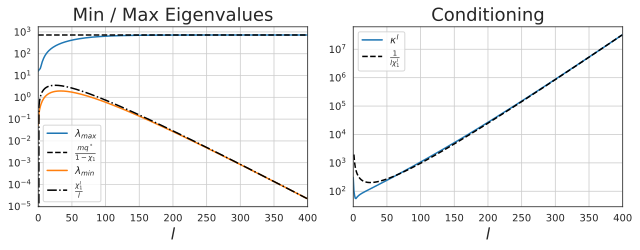

In [ ]:
W = W_ordered

lambda_min, lambda_max, kappa = spectral_info(ntk(W, b, layers)(x_train, x_train))

plt.subplot(1, 2, 1)

# Plot the diagonal and off-diagonal terms against the fixed point prediction.
plt.semilogy(lambda_max, label='$\\lambda_{max}$')
m = x_train.shape[0]
plt.semilogy([0, nlayers], [m * p_star, m * p_star], 'k--', label='$\\frac{mq^*}{1- \\chi_1}$')
plt.semilogy(lambda_min, label='$\\lambda_{min}$')
plt.semilogy(scale(chi_1(W, b) ** layers * layers, lambda_min), 'k-.', label='$\\frac{\\chi_1^l}{l}$')

# plt.ylim([10 ** -2, 10 ** 2])
plt.xlim([0, nlayers])
plt.legend()

format_plot('Min / Max Eigenvalues', '$l$')

plt.subplot(1, 2, 2)

plt.semilogy(kappa, label='$\\kappa^l$')
plt.semilogy(scale(1 / (chi_1(W, b) ** layers * layers), kappa), 'k--', label='$\\frac{1}{l\\chi_1^l}$')

plt.xlim([0, nlayers])
plt.legend()

format_plot('Conditioning', '$l$')
finalize_plot((1.5, 0.6))

Here we see that as depth increases the conditioning of the NTK deteriorates. It follows that at large depths neural networks will become untrainable. Neglecting the polynomial correction, we expect conditioning of neural networks to become too poor to train at a depth that is governed by $\xi_1 =  1/ \log\chi_1$.

Next we describe the behavior of the mean predictor in the large depth limit. In the ordered phase, as we show in [Xiao et al](), we expect $P(\Theta^l)Y_{\text{train}}$ to approach a data-dependent constant as $l\to\infty$ even though $\Theta^l$ approaches a singular, data independent, matrix. We can see this now by plotting different components of $P(\Theta^l)Y_{train}$.

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_py3_schsam.kernel.schsam.263115371177.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/IPython/core/formatters.py:249: FormatterWarning: application/pdf formatter returned invalid type <class 'bytes'> (expected (<class 'str'>,)) for object: <Figure size 480x360 with 1 Axes>


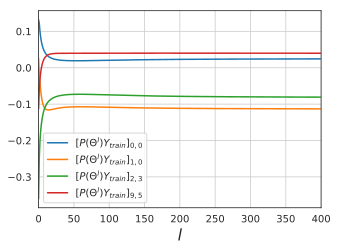

In [ ]:
W = W_ordered

delta = mean_predictor(ntk(W, b, layers), x_train, y_train, x_test)

indices = [(0, 0), (1, 0), (2, 3), (9, 5)]

for i, j in indices:
  plt.plot(delta[:, i, j], label='$[P(\\Theta^l)Y_{train}]_{' + str(i) + ',' + str(j) + '}$')

plt.legend()

plt.xlim([0, nlayers])

format_plot('', '$l$')
finalize_plot((0.8, 0.6))

# Comparison with Exact NTK Training

As described above and in [Xiao et al.](), we have proposed the conditioning number, $\kappa^{(l)}$, as a metric for **trainability** and $\Delta^{(l)}$ as a metric for **generalization**. In particular, we suspected neural networks will be trainable if $\kappa^{(l)}$ is not too large and will fail to generalize if $\Delta^{(l)}$ is too small. The evolution of these two metrics in the different phases are summarized below.
1. **Chaotic Phase**. $\kappa^{(l)}\to 1$ but $\Delta^{(l)} = O\left(\frac{\chi_c^l}{\chi_1^l}\right)$. That is too say, optimization becomes easy in the chaotic phase, but generalization suffers. After about $C\xi_*$ layers, for some constant $C$ with $\xi_* = -1/(\log\chi_{c^*} - \log\chi_1)$, the network will perfectly memorize the training set but completely fail to generalize. In this regime, the neural network behaves like a hash function.
2. **Ordered Phase**. Here, $\chi_1<1$ and $\kappa^{(l)}$ grows like $l\chi_1^l$ and so trainability will suffer after $C\xi_1$ layers for some $C$ and $\xi_1 = -1./\log \chi_1$. However, we see that the mean predictor remains data dependent at all depths and so we expect networks to generalize wherever they can be trained.

\

To test these results in practice one would like to train neural networks of varying depth and hyperparameters. However, one really would like to train a number of configurations at large depth, these experiments are not amenable to a colab notebook (see the paper for such results). However, we can verify our results by considering gradient flow on **infinite** width neural networks where the NTK has been shown to govern dynamics. A number of results have now shown that real neural networks at small learning rate have dynamics that match gradient flow dynamics and so this will be a computationally cheap way to provide preliminary evidence of our claims in an interactive medium.

\

We will take the learning rate to be $\frac 2 {\lambda_{\text max}(\Theta_{\text{train, train}})}$ in which case the training time, $t$, will correspond with the number of training steps in the full-batch gradient descent setting. To begin with, we will load a larger subset of CIFAR10 for use here. As above, feel free to play around with the dataset size (though things will run more slowely if you use a larger dataset).


In [ ]:
x_train, y_train, x_test, y_test = tuple(np.array(x) for x in get_dataset('cifar10', 256, 10000))

We will then write a function that computes the training and test accuracy for a specific set of hyperparameters at a given set of times.

In [ ]:
# Compute accuracies from predictions at different times.
@partial(vmap, in_axes=(0, None))
def accuracy(predictions, labels):
  return np.mean(np.argmax(predictions, axis=-1) == np.argmax(labels, axis=-1))

@jit
# Run the experiment for different weight variances simultaneously.
@partial(vmap, in_axes=(0, None, None, None))
def experiment(W_var, b_var, layers, ts):
  W_std = np.sqrt(W_var)
  b_std = np.sqrt(b_var)

  dlayers = np.concatenate((layers[1:] - layers[:-1], np.array([0,])))

  input_to_kernel = partial(
      stax.Dense(1024)[2], get=('cov1', 'nngp', 'cov2', 'ntk'))
  kernel_fn = wrap(stax.serial(stax.Dense(1024, W_std, b_std), stax.Erf())[2])

  def body_fn(kernels, dlayer):
    kdd, ktd = kernels

    # Make predictions for the current set of kernels at all the different times.
    lambda_max = np.linalg.eigh(kdd.ntk)[0][-1]
    eta = y_train.size * 2. / lambda_max
    predict_fn = nt.predict.gradient_descent_mse(kdd.ntk, y_train)
    predict_fn = partial(predict_fn, fx_test_0=0., k_test_train=ktd.ntk)
    train, test = vmap(predict_fn)(ts)

    # Compute the next kernel after iterating the map for dlayers.
    kdd = lax.fori_loop(0, dlayer, lambda _, k: kernel_fn(k), kdd)
    ktd = lax.fori_loop(0, dlayer, lambda _, k: kernel_fn(k), ktd)

    return (kdd, ktd), (accuracy(train, y_train), accuracy(test, y_test))

  kdd = input_to_kernel(x_train, x_train)
  ktd = input_to_kernel(x_test, x_train)

  return lax.scan(body_fn, (kdd, ktd), dlayers)[1]

We must also define the relevant depth scales for the experiment.

In [ ]:
@partial(vmap, in_axes=(0, None))
def xi_1(W_var, b_var):
  # depth scale of trainability/generalization in the ordered phase.
  return 1./ (np.abs(np.log(chi_1(W_var, b_var)))  + 1e-12 )

@partial(vmap, in_axes=(0, None))
def xi_star(W_var, b_var):
  # depth scale for generaliztion of NTK in the chaotic phase.
  return 1. /(-np.log(chi_c(W_var, b_var)) + np.log(chi_1(W_var, b_var)))

Then we can define the experiment, train all of the models, and compute the depth scales.

In [ ]:
# Experiment parameters.
W_var = np.linspace(0.5, 3.0, 40)
W_critical = 1.76
b_var = 0.18

dts = np.array([8**k for k in range(5)])
layers=np.array([i for i in range(10)] + [10 + 5*i for i in range(20)])

# Train all of the infinite networks.
train_acc, test_acc = experiment(W_var, b_var, layers, dts)

# Rearrange the axes so they go [time, depth, weight_variance].
train_acc = np.transpose(train_acc, (2, 1, 0))
test_acc = np.transpose(test_acc, (2, 1, 0))

# Compute the depth scales.
W_ordered = np.array([W for W in W_var if W < W_critical])
W_chaotic = np.array([W for W in W_var if W > W_critical])

xi_1s = xi_1(W_ordered, b_var)
xi_stars = xi_star(W_chaotic, b_var)

Finally we can plot the training / testing accuracy in a contour plot with the depth scales identified above overlayed in dashed white lines. Note that in the chaotic phase the networks achieve perfect training accuracy but completely fail to generalize.

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_py3_schsam.kernel.schsam.534982913092.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/IPython/core/formatters.py:249: FormatterWarning: application/pdf formatter returned invalid type <class 'bytes'> (expected (<class 'str'>,)) for object: <Figure size 1500x600 with 12 Axes>


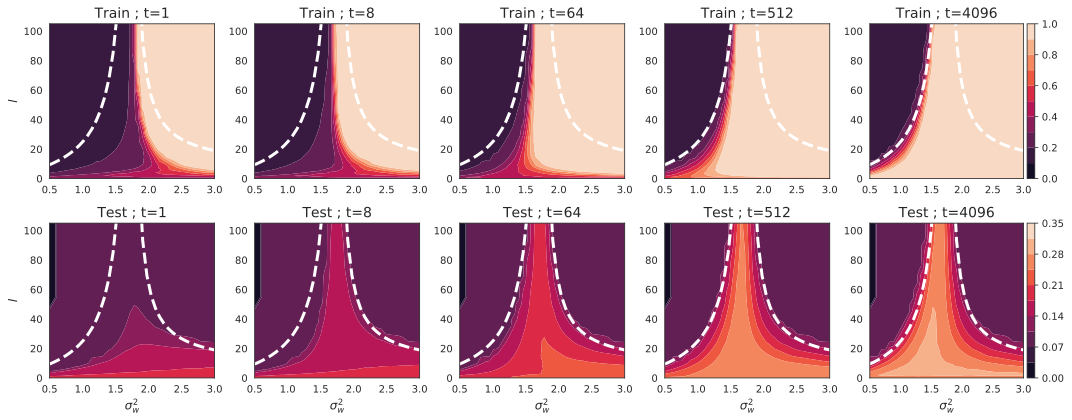

In [ ]:
ndts = len(dts)
train_levels = np.linspace(0, 1, 11)
test_levels = np.linspace(0, 0.35, 11)
depth_scaling = 8.

for i, dt in enumerate(dts):
  plt.subplot(2, ndts, i + 1)
  im = plt.contourf(W_var, layers, train_acc[i], train_levels)
  plt.plot(W_ordered, depth_scaling * xi_1s, 'w--', linewidth=3)
  plt.plot(W_chaotic, depth_scaling * xi_stars, 'w--', linewidth=3)
  plt.title('Train ; t={}'.format(dt), fontsize=14)
  if i == 0:
    plt.ylabel('$l$', fontsize=12)
  plt.ylim([0, layers[-1]])
  if i == ndts - 1:
    cax = make_axes_locatable(plt.gca()).append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)

  plt.subplot(2, ndts, ndts + i + 1)
  im = plt.contourf(W_var, layers, test_acc[i], test_levels)
  plt.title('Test ; t={}'.format(dt), fontsize=14)
  plt.plot(W_ordered, depth_scaling * xi_1s, 'w--', linewidth=3)
  plt.plot(W_chaotic, depth_scaling * xi_stars, 'w--', linewidth=3)
  plt.xlabel('$\\sigma_w^2$', fontsize=12)
  if i == 0:
    plt.ylabel('$l$', fontsize=12)
  plt.ylim([0, layers[-1]])
  if i == ndts - 1:
    cax = make_axes_locatable(plt.gca()).append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)

finalize_plot((ndts / 2, 1.))
